# PWBI Admin API Data Pull

In [1]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from urllib.parse import urljoin
from azure.identity import InteractiveBrowserCredential
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Key Functions

In [3]:
def update_key_globals(show_display=False):
    global access_token, base_url, header
    credential = InteractiveBrowserCredential()
    credential.authenticate()
    api = 'https://analysis.windows.net/powerbi/api/.default'
    access_token = credential.get_token(api).token
    base_url = 'https://api.powerbi.com/v1.0/myorg/'
    header = {'Authorization': f'Bearer {access_token}'}
    if show_display:
        print(f"Updated Access Token \n{access_token}")
    return None

def make_api_call(url, params, headers):
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 403:
        update_key_globals()
        response = requests.get(url, params=params, headers=headers)
    elif response.status_code == 404:
        response = None
    return response
    
def single_api_call(path, params, record_path='value'):
    file_name = path.split('/')[-1]
    url = urljoin(base_url, path)
    response = make_api_call(url, params, header)
    if response == None:
        return pd.DataFrame()
    elif response.status_code == 200:
        df = pd.json_normalize(response.json(), record_path = record_path)
        df.to_csv(f'data/{file_name}.csv')
        return df
    else:
        print(f"Error: {response.status_code} at {response.url} with message \n{response.json()}")
        return None

## Activity API

In [4]:
def activity_json_to_df(response, record_path='activityEventEntities'):
    response_json = response.json()
    df = pd.json_normalize(response_json, record_path=record_path)
    continuation_uri = response_json['continuationUri']
    last_result_set = response_json['lastResultSet']
    return last_result_set, continuation_uri, df
    

def get_view_report_activities(start_date='2023-11-18',end_date='2023-12-17'):

    # Convert to datetime objects
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    delta = timedelta(hours=23, minutes=59, seconds=59, milliseconds=999)

    # Generate dates
    start_dates = []
    end_dates = []
    current = start
    while current <= end:
        start_dates.append(current.strftime("%Y-%m-%dT%H:%M:%S.000Z"))
        end_dates.append((current + delta).strftime("%Y-%m-%dT%H:%M:%S.000Z"))
        current += timedelta(days=1)
        

    # Calling the API
    path = 'admin/activityevents'
    url = urljoin(base_url, path)
    
    # Initialize the final activity dataframe
    view_activity_df = []
    
    for start, end in tqdm(zip(start_dates, end_dates), total=len(start_dates)):

        # Initializing Parameters for the API Call
        params = {
            'startDateTime': f"'{start}'",
            'endDateTime': f"'{end}'",
            '$filter': "Activity eq 'viewreport'"
        }
        
        # Calling the Final API URL
        response = make_api_call(url, params, header)

        if response.status_code == 200:
            last_result_set, continuation_uri, first_df = activity_json_to_df(response)
            date_lvl_data = [first_df]
            
            while not last_result_set:
                response = make_api_call(continuation_uri, {}, header)
                if response.status_code == 200:
                    last_result_set, continuation_uri, continuation_df = activity_json_to_df(response)
                    date_lvl_data.append(continuation_df)
                else:
                    print(f"Error: {response.status_code} at {response.url} with \n{response.json()}")
                    break

            view_activity_df.extend(date_lvl_data)
        else:
            print(f"Error: {response.status_code} at {response.url} with \n{response.json()}")
            break
    
    return pd.concat(view_activity_df, axis=0) if view_activity_df else pd.DataFrame()

### Activity Exploration

In [5]:
update_key_globals()

In [6]:
# Calling the API Function
start_date='2023-11-28'
end_date='2023-12-28'

if os.path.isfile(f"data/reportViewActivity{start_date}_{end_date}.csv"):
    df_view_activity = pd.read_csv(f"data/reportViewActivity{start_date}_{end_date}.csv")
else:
    df_view_activity = get_view_report_activities(start_date, end_date)
    df_view_activity.to_csv(f"data/reportViewActivity{start_date}_{end_date}.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [07:36<00:00, 14.74s/it]


In [7]:
# Ensure CreationTime is a datetime object
df_view_activity['CreationTime'] = pd.to_datetime(df_view_activity['CreationTime'])

# Convert the datetime to timezone-aware (assuming original is UTC)
df_view_activity['CreationTime'] = df_view_activity['CreationTime'].dt.tz_localize('UTC')

# Now convert to 'Asia/Dubai' timezone
df_view_activity['CreationTimeLocal'] = df_view_activity['CreationTime'].dt.tz_convert('Asia/Dubai')

# Extracting date and time
df_view_activity['ActivityDate'] = df_view_activity['CreationTimeLocal'].dt.date
df_view_activity['ActivityTime'] = df_view_activity['CreationTimeLocal'].dt.time
df_view_activity['Activityhour'] = df_view_activity['CreationTimeLocal'].dt.hour

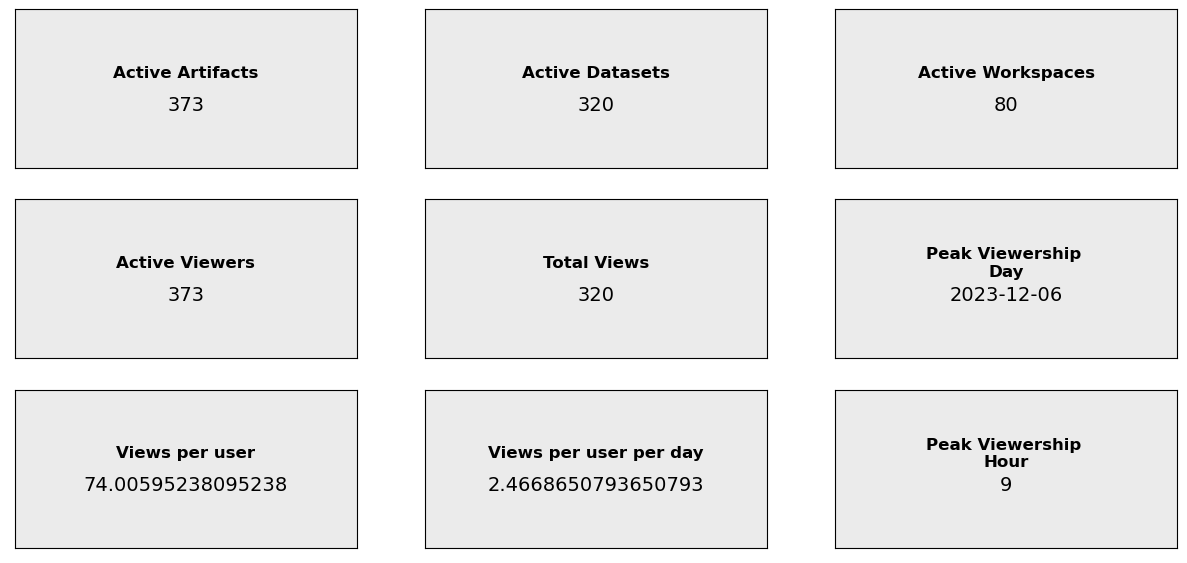

In [8]:
# Total Number of active workspaces
active_workspaces = df_view_activity['WorkspaceId'].nunique()

# Total Number of active artifacts
active_artifacts = df_view_activity['ArtifactId'].nunique()

# Total Number of active Datasets
active_datasets = df_view_activity['DatasetId'].nunique()

# Total Unique Users in the last 30 days
active_users = df_view_activity['UserKey'].nunique()

# Total Number of Views in the last 30 Days
total_views = df_view_activity['ActivityId'].nunique()

# Average Views per User
views_per_user = df_view_activity['ActivityId'].nunique()/df_view_activity['UserKey'].nunique()

# Average Views per User per day
views_per_user_per_day = df_view_activity['ActivityId'].nunique()/df_view_activity['UserKey'].nunique()/30

# Peak Viewership Day
peak_viewership_day = df_view_activity.groupby('ActivityDate')['UserKey'].nunique().idxmax()

# Peak Viewship Hour
peak_viewership_hour = df_view_activity.groupby('Activityhour')['UserKey'].nunique().idxmax()

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,7))


def create_kpi_box(ax, title, value, color):
    # Use the entire axes to draw the rectangle
    ax.add_patch(Rectangle((0, 0), 1, 1, color=color, alpha=0.3, transform=ax.transAxes))

    # Add text
    ax.text(0.5, 0.6, title, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.4, value, ha='center', va='center', fontsize=14, transform=ax.transAxes)

    # Remove the x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Creating KPI boxes
create_kpi_box(ax[0,0], 'Active Artifacts', f'{active_artifacts}', 'silver')
create_kpi_box(ax[0,1], 'Active Datasets', f'{active_datasets}', 'silver')
create_kpi_box(ax[0,2], 'Active Workspaces', f'{active_workspaces}', 'silver')
create_kpi_box(ax[1,0], 'Active Viewers', f'{active_artifacts}', 'silver')
create_kpi_box(ax[1,1], 'Total Views', f'{active_datasets}', 'silver')
create_kpi_box(ax[1,2], 'Peak Viewership \nDay', f'{peak_viewership_day:%Y-%m-%d}', 'silver')
create_kpi_box(ax[2,0], 'Views per user', f'{views_per_user}', 'silver')
create_kpi_box(ax[2,2], 'Peak Viewership \nHour', f'{peak_viewership_hour}', 'silver')
create_kpi_box(ax[2,1], 'Views per user per day', f'{views_per_user_per_day}', 'silver')

plt.show()

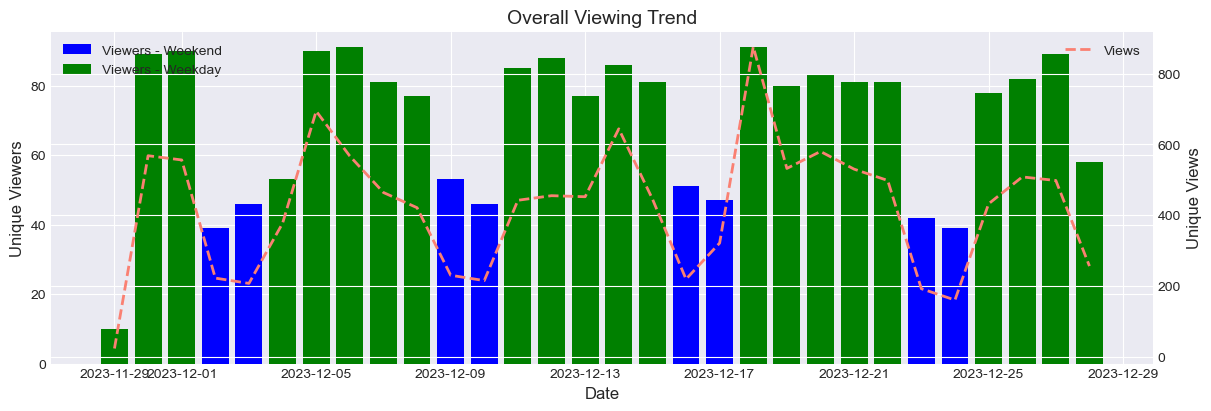

In [9]:
# Viewer Trend
view_trend = df_view_activity.groupby('ActivityDate').agg({
    'UserKey': lambda x:x.nunique(),
    'ActivityId': lambda x:x.nunique()
}).reset_index().set_index('ActivityDate')

# Converting index to datetime
view_trend.index = pd.to_datetime(view_trend.index)

# Identify weekends
weekends = view_trend.index.weekday >= 5

plt.style.use('seaborn-darkgrid')  # Example of setting a style

fig, ax = plt.subplots(figsize=(12, 4), layout='constrained')

# Bar chart
# Coloring weekends differently
ax.bar(view_trend.index[weekends], view_trend.loc[weekends, 'UserKey'], label='Viewers - Weekend', color='blue')
ax.bar(view_trend.index[~weekends], view_trend.loc[~weekends, 'UserKey'], label='Viewers - Weekday', color='green')


# Line plot with a secondary axis
ax2 = ax.twinx()
ax2.plot(view_trend.index, view_trend['ActivityId'], label='Views', color='salmon', linestyle='--', linewidth=2)

# Enhancements
ax.set_title("Overall Viewing Trend", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Unique Viewers", fontsize=12)
ax2.set_ylabel("Unique Views", fontsize=12)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date
plt.xticks(rotation=45)

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.grid(True)


## Workspace Expanded Reports

In [ ]:
path = 'admin/groups'
params = {
    '$expand': 'reports',
    '$top': 1000
}

if 'df_groups' not in globals():
    try:
        df_groups = pd.read_csv(f"data/{path.split('/')[-1]}.csv")
    except FileNotFoundError:
        df_groups = single_api_call(path, params, record_path='value')  
        df_groups.to_csv(f"data/{path.split('/')[-1]}.csv")
        
print(f"Shape of the extracted data is {df_groups.shape}")

In [10]:
path = 'admin/groups'
params = {
    '$expand': 'reports',
    '$top': 1000
}

url = urljoin(base_url, path)
response = make_api_call(url, params, header)
if response == None:
    df_groups_e = pd.DataFrame()
elif response.status_code == 200:
    json_groups_e = response.json()['value']
    df_groups_e = pd.json_normalize(
        json_groups_e,
        record_path='reports',
        meta=[
            'id','isOnDedicatedCapacity', 'capacityMigrationStatus',
            'type','state','name','capacityId','defaultDatasetStorageFormat'
        ],
        errors='ignore',
        meta_prefix='workspace_'
)
else:
    print(f"Error: {response.status_code} at {response.url} with message \n{response.json()}")

In [11]:
df_groups_e = df_groups_e[
    [
        'workspace_id','workspace_name','workspace_type','workspace_state',
        'workspace_isOnDedicatedCapacity','workspace_capacityMigrationStatus',
        'workspace_capacityId','workspace_defaultDatasetStorageFormat',   
        'id', 'name', 'datasetId', 'appId', 'createdDateTime', 'modifiedDateTime'
    ]
].copy()
df_groups_e = df_groups_e[df_groups_e['workspace_type'] == 'Workspace'].copy()
df_groups_e.rename(
    {
        'id': 'report_id',
        'name': 'report_name',
        'createdDateTime': 'reportCreatedDatetime',
        'modifiedDateTime': 'reportModifiedDatetime'
    },
    inplace=True,
    axis=1
)

In [12]:
print(f"Shape of groups = {df_groups_e.shape}")
df_groups_e.to_csv('data/groups_e.csv')

Shape of groups = (1062, 14)


In [ ]:
df_active_groups = df_groups_e[df_groups_e['workspace_state']=='Active'].copy()
print(f"Shape of active groups = {df_active_groups.shape}")
df_active_groups.to_csv('data/active_groups_e.csv')

In [ ]:
df_active_groups_2 = pd.merge(
    left = df_active_groups[df_active_groups['appId'].isna()==True],
    right = df_active_groups[df_active_groups['appId'].isna()==False][
        [
            'workspace_id','datasetId','report_id','report_name','appId','reportCreatedDatetime','reportModifiedDatetime'
        ]
    ],
    how = 'left',
    left_on = ['workspace_id','datasetId'],
    right_on = ['workspace_id','datasetId']
)

df_active_groups_2 = df_active_groups_2[
    [
        'workspace_id', 'workspace_name', 'workspace_type', 'workspace_state',
        'workspace_isOnDedicatedCapacity', 'report_id_x', 'report_name_x', 
        'datasetId','reportCreatedDatetime_x', 'reportModifiedDatetime_x', 
        'report_id_y', 'report_name_y', 'appId_y', 'reportCreatedDatetime_y',
        'reportModifiedDatetime_y'
    ]
].copy()

df_active_groups_2.rename(
    {
        'report_id_x': 'report_id',
        'report_name_x': 'report_name',
        'reportCreatedDatetime_x': 'reportCreatedDatetime',
        'reportModifiedDatetime_x': 'reportModifiedDatetime',
        'report_id_y': 'app_report_id',
        'report_name_y': 'app_report_name',
        'reportCreatedDatetime_y': 'app_reportCreatedDatetime',
        'reportModifiedDatetime_y': 'app_reportModifiedDatetime',
        'appId_y': 'appId'
    },
    axis=1,
    inplace=True

)

# Fill NaNs to carry out str operations
df_active_groups_2['app_report_name'].fillna('Not Applicable', inplace=True)

# Itentify duplicate matches
df_active_groups_2['duplicate_match_flag'] = df_active_groups_2.apply(lambda x: 1 if ((x['report_name'].strip() in x['app_report_name'].strip()) or (x['app_report_name'] == 'Not Applicable')) else 0, axis=1)

In [ ]:
df_active_groups_2[df_active_groups_2['duplicate_match_flag'] == 0].shape

In [ ]:
df_active_groups_2.head()

In [ ]:
print(df_active_groups_2.columns)
df_active_groups_2.to_csv('data/active_groups_e_2.csv')

## Reports List

In [ ]:
path = 'admin/reports'
params = {}

if 'df_reports' not in globals():
    try:
        df_reports = pd.read_csv(f"data/{path.split('/')[-1]}.csv")
    except FileNotFoundError:
        df_reports = single_api_call(path, params, record_path='value')  
        
print(f"Shape of the extracted data is {df_reports.shape}")

Merging the Workspace data with reports enrich with report details & shortlisting records associated to BI&A COE members

In [ ]:
# Shortlisting necessary columns only   
df_reports = pd.merge(left=df_reports, right=df_groups[['id','name']], how='left', left_on='workspaceId', right_on='id')

df_reports = df_reports[
    [
        'id_x','name_x', 'description','webUrl', 'datasetId',
        'workspaceId','name_y','appId','createdDateTime',
        'createdBy','modifiedDateTime','modifiedBy'
    ]
].rename(
    {
        'id_x': 'reportId',
        'name_x': 'reportName',
        'name_y': 'workspaceName'
    }, 
    axis='columns'
).copy()

# Shortlisting relevant rows
df_reports = df_reports[df_reports['appId'].isna() == True]
df_reports = df_reports[df_reports['createdBy'].isin(
    [
        'balu.r@gagroup.net','Prajwal.G@gagroup.net', 'Sachin.bm@gagroup.net',
        'lakshmi.n@gagroup.net','adithi.j@gagroup.net', 'elizabeth@gagroup.net',
        'pooja.s@gagroup.net', 'aravindhakshan.r@gagroup.net'
    ]
)]
print(f"Shape of the updated reports dataframe is {df_reports.shape}")

Merging with aggregated view activity data at report level

In [ ]:
# Report level viewer count in last 30 days 
report_viewer_cnt = df_view_activity.groupby('ReportId').agg({'UserKey': lambda x:x.nunique()}).reset_index()

# Populate against universe of reports
df_reports = pd.merge(left=df_reports, right=report_viewer_cnt, how='left', left_on='reportId', right_on='ReportId')

print(f"Shape of the updated reports dataframe is {df_reports.shape}")

## Datasets

In [ ]:
# Get Datasets
path = 'admin/datasets'
params = {}

if 'df_datasets' not in globals():
    try:
        df_datasets = pd.read_csv(f"data/{path.split('/')[-1]}.csv")
    except FileNotFoundError:
        df_datasets = single_api_call(path, params, record_path='value')  
        
print(f"Shape of the extracted data is {df_datasets.shape}")

In [ ]:
df_datasets[df_datasets['name'] == 'Range_Report_v11pbix']

Merging the Workspace & Reports data with Datasets data to enrich with report details 

In [ ]:
del df_master

In [ ]:
df_master = pd.merge(left=df_reports, right=df_datasets[['id', 'name', 'configuredBy','isRefreshable','createdDate']], how='left', left_on='datasetId', right_on='id')
df_master = df_master[
    [
        'reportId', 'reportName', 'description', 'webUrl', 'datasetId',
        'name','configuredBy', 'isRefreshable', 'createdDate','workspaceId', 
        'workspaceName', 'appId', 'createdDateTime', 'createdBy',
        'modifiedDateTime', 'modifiedBy', 'ReportId', 'UserKey'
    ]
].rename(
    {
        'name': 'datasetName',
        'configuredBy': 'datasetConfiguredBy',
        'isRefreshable': 'datasetIsRefreshable',
        'createdDate': 'datasetCreatedDate'
    }, 
    axis='columns'
).copy()
df_master.head(3)

print(f"Shape of the updated reports dataframe is {df_reports.shape}")

## Refresh Schedule

In [ ]:
# For every refreshable, get the refresh schedule
df_refresh_schedule = pd.DataFrame()
for dataset in tqdm(df_master[df_master['datasetIsRefreshable']==True]['datasetId']): 
    path = f'datasets/{dataset}/refreshSchedule'
    params = {}
    inner_df = single_api_call(path, params, record_path=None)
    inner_df['datasetId'] = dataset
    df_refresh_schedule = pd.concat([df_refresh_schedule,inner_df], axis=0)

# Converting the list stored in the dataframe to csv (Prerequisite for the next step)
df_refresh_schedule.days = df_refresh_schedule.days.apply(lambda x: ','.join(x))
df_refresh_schedule.times = df_refresh_schedule.times.apply(lambda x: ','.join(x))

# Dropping duplicates
df_refresh_schedule.drop_duplicates(inplace=True)

# Creating a persistent copy
df_refresh_schedule.to_csv('data/refresh_schedule.csv')

In [ ]:
df_master = pd.merge(left=df_master, right=df_refresh_schedule[['datasetId', 'times', 'days','enabled','localTimeZoneId']], how='left', left_on='datasetId', right_on='datasetId')
df_master = df_master[
    [
        'reportId', 'reportName', 'description', 'webUrl', 'datasetId',
        'datasetName', 'datasetConfiguredBy', 'datasetIsRefreshable', 'datasetCreatedDate',
        'times', 'days', 'enabled', 'localTimeZoneId', 'workspaceId', 'workspaceName', 'appId', 
        'createdDateTime', 'createdBy','modifiedDateTime', 'modifiedBy', 'ReportId', 'UserKey'
    ]
].rename(
    {
        'times': 'refreshTimes',
        'days': 'refreshDays',
        'enabled': 'refreshEnabled',
    }, 
    axis='columns'
).copy()
print(f"Shape of the updated reports dataframe is {df_master.shape}")

### Refresh History

In [ ]:
# For every refreshable, get the refresh schedule
df_refresh_history = pd.DataFrame()
for dataset in tqdm(df_reports[df_reports['datasetIsRefreshable']==True]['datasetId']): 
    path = f'datasets/{dataset}/refreshes'
    params = {}
    inner_df = single_api_call(path, params, record_path='value')
    inner_df['datasetId'] = dataset
    df_refresh_history = pd.concat([df_refresh_history,inner_df], axis=0)
    
df_refresh_history['startTime'] = pd.to_datetime(df_refresh_history['startTime']).dt.tz_convert('Asia/Dubai')
df_refresh_history['endTime'] = pd.to_datetime(df_refresh_history['endTime']).dt.tz_convert('Asia/Dubai')
df_refresh_history['refreshDuration'] = df_refresh_history['endTime']-df_refresh_history['startTime']

print(f"Shape of refresh history df {df_refresh_history.shape}")
df_refresh_history.head()

In [ ]:
df_dataset_refresh_stats = df_refresh_history.groupby('datasetId').agg({
    'startTime': 'max',
    'refreshDuration': 'mean'
}).reset_index().rename(
    {
        'startTime': 'latestRefreshDate',
        'refreshDuration': 'avgRefreshDuration'
    }, axis=1)
df_dataset_refresh_stats.columns

In [ ]:
df_master = pd.merge(left=df_master, right=df_dataset_refresh_stats, how='left', left_on='datasetId', right_on='datasetId')
df_master.columns
df_reports = df_reports[
    [
        'reportId', 'reportName', 'description', 'webUrl', 'datasetId',
        'datasetName', 'datasetConfiguredBy', 'datasetIsRefreshable', 'datasetCreatedDate',
        'refreshTimes', 'refreshDays', 'refreshEnabled', 'localTimeZoneId', 'avgRefreshDuration','latestRefreshDate', 
        'workspaceId', 'workspaceName', 'appId', 'createdDateTime', 'createdBy','modifiedDateTime', 
        'modifiedBy', 'ReportId', 'UserKey'
    ]
].copy() 
df_reports['avgRefreshDuration'] = df_reports['avgRefreshDuration'].dt.seconds/60
print(f"Shape of the updated reports dataframe is {df_reports.shape}")

In [ ]:
df_reports.to_csv('data/master_ref_table.csv')

## Appendix

In [ ]:
# old logic for updating access_token globals
credential = InteractiveBrowserCredential()
credential.authenticate()

api = 'https://analysis.windows.net/powerbi/api/.default'
access_token = credential.get_token(api)
access_token = access_token.token

access_token

In [ ]:
base_url = 'https://api.powerbi.com/v1.0/myorg/'
header = {'Authorization': f'Bearer {access_token}'}

In [ ]:
# Old logic for activities
path = 'admin/activityevents'
url = urljoin(base_url, path)

final_df = pd.DataFrame()

for each in tqdm(zip(start_dates, end_dates), total=len(start_dates)):

    initial_df = pd.DataFrame()
    intermediate_df = pd.DataFrame()
    pen_df = pd.DataFrame()

    params = {
        'startDateTime': f"'{each[0]}'",
        'endDateTime': f"'{each[-1]}'",
        '$filter': "Activity eq 'viewreport'"
    }

    initial_response = requests.get(url, params=params, headers=header)

    if initial_response.status_code == 200:
        initial_df = pd.json_normalize(initial_response.json(), record_path='activityEventEntities')
        continuation_uri = initial_response.json()['continuationUri']
        last_result_set = initial_response.json()['lastResultSet']
        while last_result_set == False:
            intermediate_response = requests.get(continuation_uri, headers=header)
            if intermediate_response.status_code == 200:
                intermediate_df = pd.json_normalize(intermediate_response.json(), record_path='activityEventEntities')
                pen_df = pd.concat([pen_df,intermediate_df ], axis = 0)
                continuation_uri = intermediate_response.json()['continuationUri']
                last_result_set = intermediate_response.json()['lastResultSet']
            else:
                print(intermediate_response.status_code)
                break
        final_df = pd.concat([final_df,initial_df,pen_df], axis=0)
    else:
        print(initial_response.status_code)
        print(initial_response.url)
        print(initial_response.json)
        break 
    